In [ ]:
# This specific version of torchvision is needed to download the mnist set
# !pip3 install torch torchvision

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Dataset Preparation

In [26]:
# Hyperparameters
batch_size = 64
learning_rate = 1e-3
num_epochs = 10
noise_factor = 1.5
criterion = nn.MSELoss()

# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



# Linear Autoencoder

In [ ]:
class DeepLinearAutoencoder(nn.Module):
    def __init__(self):
        super(DeepLinearAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 16),
            # nn.Linear(16, 3)
        )
        # Decoder
        self.decoder = nn.Sequential(
            # nn.Linear(3, 16),  # Increase latent code size
            nn.Linear(16, 64),
            nn.Linear(64, 128),
            nn.Linear(128, 256),
            nn.Linear(256, 512),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()  # Use sigmoid activation to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
class LinearAutoencoder(nn.Module):
    def __init__(self):
        super(LinearAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 16),
            nn.Linear(16, 8)  # Larger latent code
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.Linear(16, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 128),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Use sigmoid activation for output values ​​between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
def train(num_epochs, criterion, optimizer, model):

  for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
def reconstruct():
  with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        output = model(img)

        # Plotting the first 8 test images and their reconstructions
        fig, axes = plt.subplots( 2, 8, figsize=(12, 3))
        for i in range(8):
            axes[0, i].imshow(img[i].view(28, 28).numpy(), cmap='gray')
            axes[1, i].imshow(output[i].view(28, 28).numpy(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].axis('off')
        plt.show()
        break

Train the model with deep linear autoencoder

Epoch [1/5], Loss: 0.8867
Epoch [2/5], Loss: 0.8349
Epoch [3/5], Loss: 0.8241
Epoch [4/5], Loss: 0.8297
Epoch [5/5], Loss: 0.8779


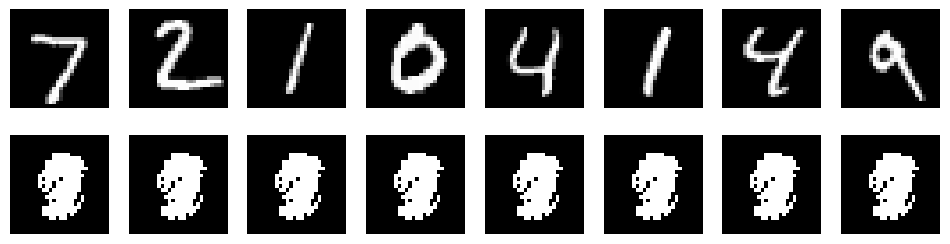

In [ ]:
model = DeepLinearAutoencoder()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train(num_epochs, criterion, optimizer, model)
reconstruct()

Train the model with a simple linear architecture, and higth code latent

Epoch [1/5], Loss: 1.2476
Epoch [2/5], Loss: 1.2622
Epoch [3/5], Loss: 1.2442
Epoch [4/5], Loss: 1.3228
Epoch [5/5], Loss: 1.2524


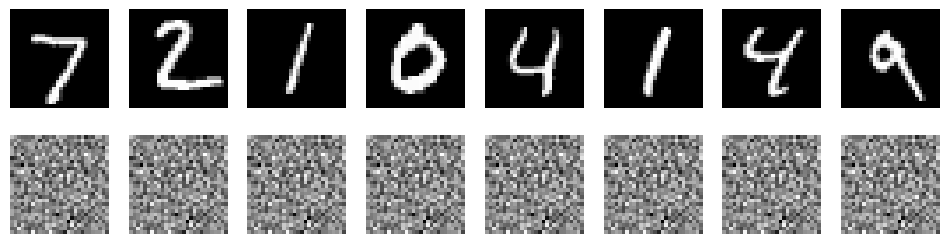

In [ ]:
model = LinearAutoencoder()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(num_epochs, criterion, optimizer, model)
reconstruct()

# Denoising Auto-Encoder

In [29]:
# Function to plot images
def plot_images(images, titles, n_col=10):
    n_row = len(images) // n_col
    fig, axes = plt.subplots(n_row, n_col, figsize=(20, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        ax = axes[i // n_col, i % n_col]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(title)
        ax.axis('off')


    plt.show()

In [30]:
def add_gaussian_noise(x):
    return x + noise_factor * torch.randn_like(x)

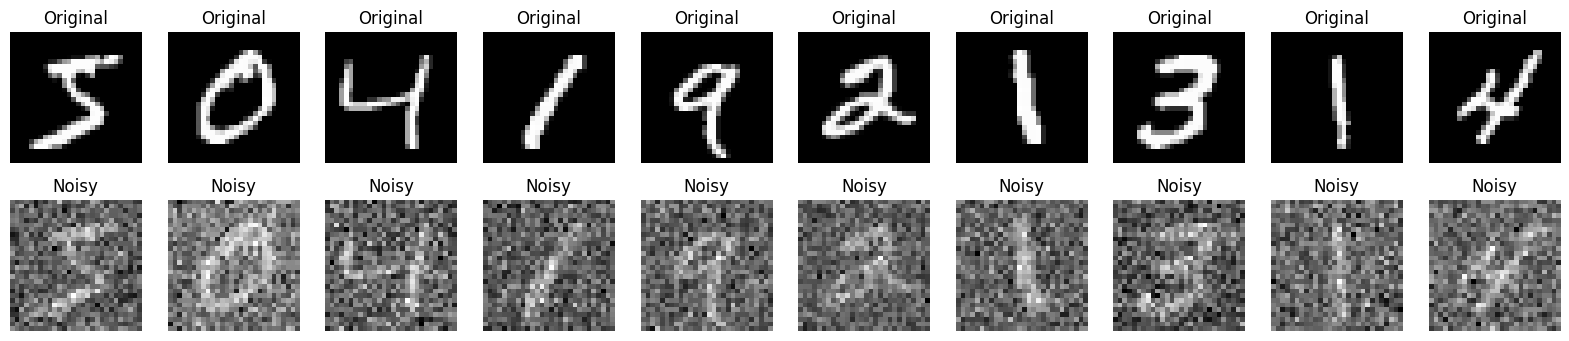

In [31]:
n_samples = 20
original_images = []
noisy_images = []
titles = []

for i in range(n_samples):
    img, _ = train_dataset[i]
    noisy_img = add_gaussian_noise(img)

    original_images.append(img)
    noisy_images.append(noisy_img)
    titles.append("Original" if i < 10 else "Noisy")

# Combine images for plotting
images_to_plot = original_images[:10] + noisy_images[:10]

# Plot the images
plot_images(images_to_plot, titles)


In [32]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [33]:
model = DenoisingAutoencoder().cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
# Training loop
losses = []
for epoch in trange(num_epochs):
    model.train()
    for data in train_loader:
        img, _ = data
        img = img.cuda()
        noisy_img = add_gaussian_noise(img).cuda()

        # Forward pass
        outputs = model(noisy_img)
        loss = criterion(outputs, img)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.cpu().detach().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 10%|█         | 1/10 [00:15<02:22, 15.80s/it]

Epoch [1/10], Loss: 0.5181


 20%|██        | 2/10 [00:32<02:12, 16.54s/it]

Epoch [2/10], Loss: 0.5213


 30%|███       | 3/10 [00:47<01:50, 15.83s/it]

Epoch [3/10], Loss: 0.5694


 40%|████      | 4/10 [01:03<01:33, 15.57s/it]

Epoch [4/10], Loss: 0.5176


 50%|█████     | 5/10 [01:18<01:17, 15.57s/it]

Epoch [5/10], Loss: 0.5562


 60%|██████    | 6/10 [01:36<01:04, 16.21s/it]

Epoch [6/10], Loss: 0.5452


 70%|███████   | 7/10 [01:51<00:47, 15.83s/it]

Epoch [7/10], Loss: 0.4949


 80%|████████  | 8/10 [02:06<00:31, 15.56s/it]

Epoch [8/10], Loss: 0.4869


 90%|█████████ | 9/10 [02:21<00:15, 15.62s/it]

Epoch [9/10], Loss: 0.5328


100%|██████████| 10/10 [02:36<00:00, 15.65s/it]

Epoch [10/10], Loss: 0.5365


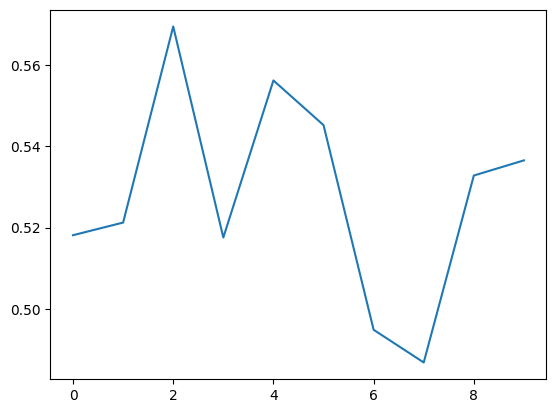

In [35]:
plt.plot(losses)

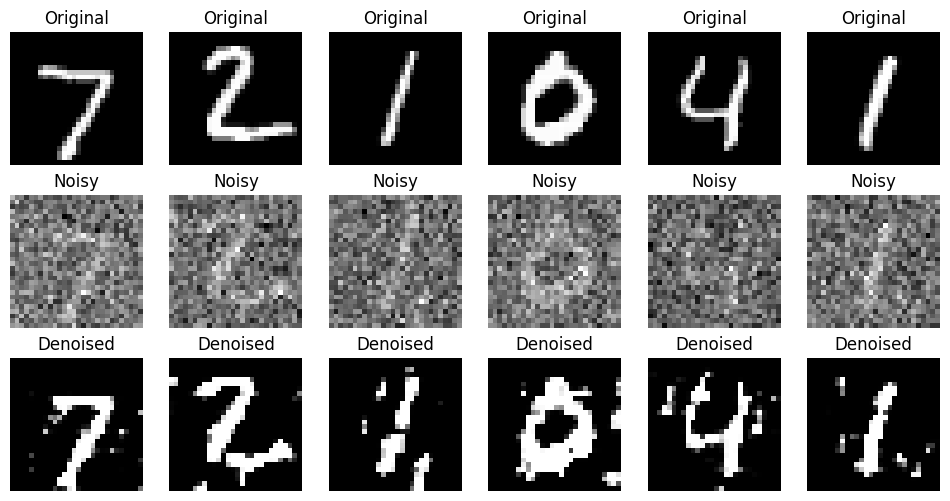

In [36]:
# Testing loop for MNIST
model.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.cuda()
        noisy_img = (img + 2 * torch.randn_like(img)).cuda()
        outputs = model(noisy_img)

        # Visualize the results
        img = img.cpu().numpy()
        noisy_img = noisy_img.cpu().numpy()
        outputs = outputs.cpu().numpy()

        fig, axes = plt.subplots(3, 6, figsize=(12, 6))
        for i in range(6):
            axes[0, i].imshow(img[i].squeeze(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            axes[1, i].imshow(noisy_img[i].squeeze(), cmap='gray')
            axes[1, i].set_title('Noisy')
            axes[1, i].axis('off')
            axes[2, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[2, i].set_title('Denoised')
            axes[2, i].axis('off')
        plt.show()
        break

# Contractive Autoencoder

In [ ]:
# Define the Contractive Autoencoder class
class ContractiveAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, lambda_):
        super(ContractiveAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, latent_dim),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Assuming input data is normalized between 0 and 1
        )

        self.lambda_ = lambda_

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent


    def contractive_loss(self, inputs, reconstruction, latent):
        criterion = nn.MSELoss()
        mse_loss = criterion(reconstruction, inputs)

        # Compute the Jacobian matrix J with respect to the latent representation
        latent_grad = torch.autograd.grad(outputs=latent, inputs=inputs,
                                          grad_outputs=torch.ones_like(latent),
                                          create_graph=True, retain_graph=True, only_inputs=True)[0]

        # Compute the Frobenius norm of the Jacobian
        J_frobenius = torch.norm(latent_grad.view(latent_grad.size(0), -1), dim=1)
        contractive_loss = torch.sum(J_frobenius ** 2)

        # Total loss
        total_loss = mse_loss + self.lambda_ * contractive_loss
        return total_loss


In [ ]:
# Parameters
input_dim = 28 * 28
latent_dim = 64

======================================== BEGINING RESULTS FOR lambda=5 ========================================
Epoch [1/5], Loss: 59.4867
Epoch [2/5], Loss: 2.0814
Epoch [3/5], Loss: 1.2630
Epoch [4/5], Loss: 1.1259
Epoch [5/5], Loss: 0.9269


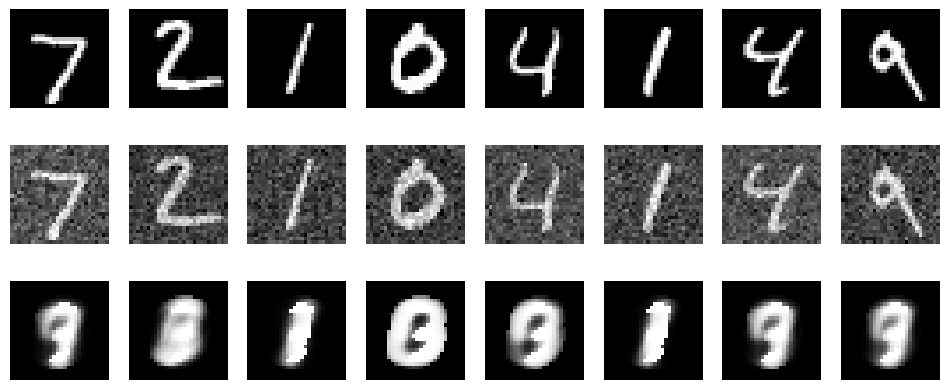

======================================== END RESULTS FOR lambda=5 ========================================

======================================== BEGINING RESULTS FOR lambda=0.0001 ========================================
Epoch [1/5], Loss: 0.8180
Epoch [2/5], Loss: 0.6701
Epoch [3/5], Loss: 0.6376
Epoch [4/5], Loss: 0.6150
Epoch [5/5], Loss: 0.5956


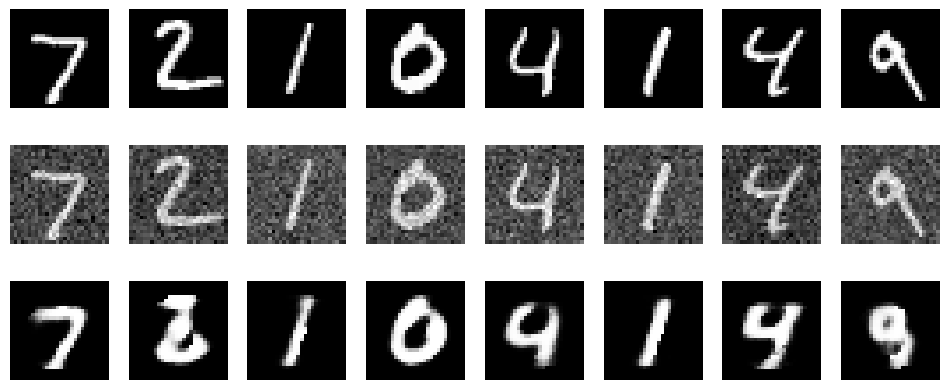

======================================== END RESULTS FOR lambda=0.0001 ========================================



In [ ]:
# Training function

for lambda_ in [5,  1e-4]:
    print('='*40,f'BEGINING RESULTS FOR lambda={lambda_}','='*40)
    model = ContractiveAutoencoder(input_dim, latent_dim, lambda_)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    def train_model(model, optimizer, train_loader, test_loader, num_epochs=10, threshold=0.05):
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0

            for inputs, _ in train_loader:
                inputs = inputs.view(inputs.size(0), -1)#.to(device)  # Flatten the input
                inputs.requires_grad = True  # Enable gradient computation for inputs

                optimizer.zero_grad()
                outputs, latent = model(inputs)
                loss = model.contractive_loss(inputs, outputs, latent)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)


            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')


    train_model(model, optimizer, train_loader, test_loader, num_epochs)


    with torch.no_grad():
        std = .5
        for data in test_loader:
            img, _ = data
            img = img.view(img.size(0), -1)
            img_noisy = img + torch.randn(img.size()) * std
            output, _ = model(img_noisy)
            # print(output.shape)
            # Plotting the first 8 test images and their reconstructions
            fig, axes = plt.subplots( 3, 8, figsize=(12, 5))
            for i in range(8):
                axes[0, i].imshow(img[i].view(28, 28).numpy(), cmap='gray')
                axes[1, i].imshow(img_noisy[i].view(28, 28).numpy(), cmap='gray')
                axes[2, i].imshow(output[i].view(28, 28).numpy(), cmap='gray')
                axes[0, i].axis('off')
                axes[1, i].axis('off')
                axes[2, i].axis('off')
            plt.show()
            break
    print('='*40,f'END RESULTS FOR lambda={lambda_}','='*40)
    print()